## Computing the incidence of a COVID-19 outcome variable (e.g. deaths), by vax status.

There are two common methodologies:
1. Compare aggregate data on deaths by vax status (numerator) to population by vax status (denominator) 
2. Compute incidence rates by tracking a representative sample of individuals

The validity of Method 1 hinges on whether we are confident in population estimates, since the unvaccinated population is not tracked in the same way that each vaccination is, and is hence derived as:

`unvax  = total population - total with at least 1 dose`

This relies on an accurate estimates of:
- Total population
- Number of vaccinated people

Vaccinations are tracked rigorously in Malaysia, but a robust population estimate may be difficult to obtain, given the ostensibly large undocumented population. 

In the context of vaccinations, an indicator that there is uncertainty over population data is when the number of vaccinations delivered exceeds the total population estimate. This problem is particularly salient in Malaysia, because primary vaccination rates are >90% across all age groups. This means that even small errors in population estimates (which are a regular feature of censusus, and not due to any fault of the census-taker) can lead to an implied negative unvaccinated group. For example, as of the 10th of March, the number of vaccinated individuals aged 50-59 exceeds the population estimate for that age group.

Therefore, it may be preferable to use Method 2, and track a representative sample of individuals, especially if a comprehensive population database is available. With such a database, COVID-19 testing, outcomes (hosp, ICU, death), and vaccination history are matched based on individual IDs; computed incidence rates are guaranteed to be bounded between 0 and 100%.

That said, this notebook is intended to demonstrate the application of Method 1. However, we use population numbers derived from our application of Method 2.

In [1]:
import pandas as pd
from tabulate import tabulate

import numpy as np
import datetime
from datetime import date, timedelta

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as tkr

linelist_deaths = '../epidemic/linelist/linelist_deaths.csv'
vax_age = '../vaccination/vax_demog_age.csv'

In [2]:
# The first set of numbers is taken directly from DOSM's latest release (Feb 14), with imputation only to back out the 18-29 group.
# This set of population numbers gives us an adult population of ~23.1mil

pop_age = {
'18_29' : 7067431,
'30_39' : 5636728,
'40_49' : 4021654,
'50_59' : 3030048,
'60_69' : 2050943,
'70_79' : 956402,
'80+' : 326759,
}

# This is the adjusted set, derived from supplementing national registration data with data collected via the vaccination program.
# This set of population numbers gives us an adult population of ~24mil, which drastically affects the size of the unvax population.
# Comment it out to use the first set.

pop_age = {
'18_29' : 7563410,
'30_39' : 5740871,
'40_49' : 4021654,
'50_59' : 3121816,
'60_69' : 2180719,
'70_79' : 1001044,
'80+' : 337123,
}

In [3]:
# Key parameters - choose timerange and whether to use date of death or date of report.
# Note: Intervals longer than 21 days are not advisable, as there may be large changes in the vax population. This requires different handling.

date_min = date(2022, 1, 1)
date_max = date(2022, 9, 30)
use_announced = 0

def vaxStatus(date_pos, date1, date2, date3):
    if (date_pos - date3).days > 6: return 'boosted'
    elif (date_pos - date2).days > 13: return 'fullyvax'
    elif (date_pos - date1).days >= 0: return 'partialvax'
    else: return 'unvax'
    
def castAge(age):
    if age == -1: return 'missing'
    elif age < 5: return '0_4'
    elif age < 12: return '5_11'
    elif age < 18: return '12_17'
    elif age < 30: return '18_29'
    elif age < 40: return '30_39'
    elif age < 50: return '40_49'
    elif age < 60: return '50_59'
    elif age < 70: return '60_69'
    elif age < 80: return '70_79'
    else: return '80+'

ages = [x for x in range(-1,150)]
age_cat = dict(zip(ages,[castAge(x) for x in ages]))

# Pull latest deaths linelist and wrangle
datecol = 'date_announced' if use_announced == 1 else 'date'
df = pd.read_csv(linelist_deaths, usecols=[datecol, 'age', 'date_positive','date_dose1','date_dose2','date_dose3','brand1'])
df = df.rename(columns={'date_announced':'date'})
for c in ['date','date_positive','date_dose1','date_dose2','date_dose3']: df[c] = pd.to_datetime(df[c],errors='coerce').dt.date
df = df[(df.date >= date_min) & (df.date <= date_max)]

# Ensure no null vax dates (future date as placeholder), shift 14 days for Cansino, then encode vax status and age group
for c in ['date_dose1','date_dose2','date_dose3']: df[c] = df[c].fillna(date.today()+timedelta(1))
df.loc[df.brand1.isin(['Cansino']),'date_dose2'] = df.date_dose1 + timedelta(14)
df['status'] = df.apply(lambda x: vaxStatus(x['date_positive'],x['date_dose1'],x['date_dose2'],x['date_dose3']),axis=1)
df = df.replace(date.today()+timedelta(1),np.nan) # Remove placeholder dates
df.age = df.age.map(age_cat) # Encode age group

# Tabulate, keeping adults only
df = df[~df.age.isin(['0_4','5_11','12_17'])].groupby(['age','status']).size().to_frame('deaths').reset_index()
df = df[~df.status.isin(['partialvax'])].reset_index(drop=True)
df.head(len(df))

,age,status,deaths
0,18_29,boosted,12
1,18_29,fullyvax,29
2,18_29,unvax,28
3,30_39,boosted,35
4,30_39,fullyvax,74
5,30_39,unvax,50
6,40_49,boosted,67
7,40_49,fullyvax,155
8,40_49,unvax,104
9,50_59,boosted,131


In [6]:
# Get vax by age data and wrangle
cols_vax = ['date'] + [x + '_' + y.replace('+','') for x in ['partial','full','booster'] for y in list(pop_age.keys())]
vf = pd.read_csv(vax_age,usecols=cols_vax)
vf.columns = [x.replace('80','80+') for x in vf.columns]
vf.date = pd.to_datetime(vf.date).dt.date
vf = vf.groupby(['date']).sum().cumsum().reset_index()

# Add unvax columns, subtract partial from unvax, full from partial, and boosted from full
for c in list(pop_age.keys()): 
    vf['unvax_' + c] = pop_age[c] - vf['partial_' + c]
    vf['partial_' + c] = vf['partial_' + c] - vf['full_' + c]
    vf['full_' + c] = vf['full_' + c] - vf['booster_' + c]
    
# Shift vax columns per definitions of partial, full, boosted
for c in [x for x in vf.columns if 'partial' in x]: vf[c] = vf[c].shift(1).fillna(0).astype(int)
for c in [x for x in vf.columns if 'full' in x]: vf[c] = vf[c].shift(14).fillna(0).astype(int)
for c in [x for x in vf.columns if 'booster' in x]: vf[c] = vf[c].shift(7).fillna(0).astype(int)

# Get mean across period and transpose to merge with deaths df
vf = vf[(vf.date >= date_min) & (vf.date <= date_max)]
vf.drop(['date'],axis=1,inplace=True)
vf.loc['pop'] = vf.mean(numeric_only=True)
vf = vf[vf.index == 'pop'].transpose().reset_index().rename(columns={'index':'cat'})
vf[['status','age']] = vf['cat'].str.split('_', 1, expand=True)
vf.status = vf.status.replace({'partial':'partialvax', 'full':'fullyvax', 'booster':'boosted'})
vf = vf[~vf.status.isin(['partialvax'])][['age','status','pop']].sort_values(by=['age','status']).reset_index(drop=True)
vf.head(len(vf))

/var/folders/ly/n1sbv1sx4bb3n3xb4f_19vmh0000gn/T/ipykernel_39972/1053183216.py:24: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  vf[['status','age']] = vf['cat'].str.split('_', 1, expand=True)


,age,status,pop
0,18_29,boosted,3.773589e+06
1,18_29,fullyvax,3.049471e+06
2,18_29,unvax,7.684683e+05
3,30_39,boosted,3.227173e+06
4,30_39,fullyvax,2.063619e+06
5,30_39,unvax,4.706313e+05
6,40_49,boosted,2.618550e+06
7,40_49,fullyvax,1.324679e+06
8,40_49,unvax,9.404472e+04
9,50_59,boosted,2.110940e+06


In [7]:
# Merge frames and compute incidence, then pivot
df = pd.merge(df,vf, on=['age','status'], how='left')
df['capita'] = df.deaths/df['pop'] * 100000
df = df.pivot(index='age', columns='status', values=['capita']).fillna(0).reset_index()
df.columns = ['age','Boosted','Fully Vaccinated','Unvaccinated']
df = df[['age','Unvaccinated','Fully Vaccinated','Boosted']]
df.head(len(df))

,age,Unvaccinated,Fully Vaccinated,Boosted
0,18_29,3.643611,0.950985,0.318000
1,30_39,10.624029,3.585934,1.084541
2,40_49,110.585690,11.700947,2.558668
3,50_59,172.887701,28.171253,6.205765
4,60_69,609.833278,74.108909,13.840787
5,70_79,1150.979164,199.703243,38.023223
6,80+,3617.005455,527.144997,138.609736


/Users/weichun/.pyenv/versions/3.9.10/envs/vega/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


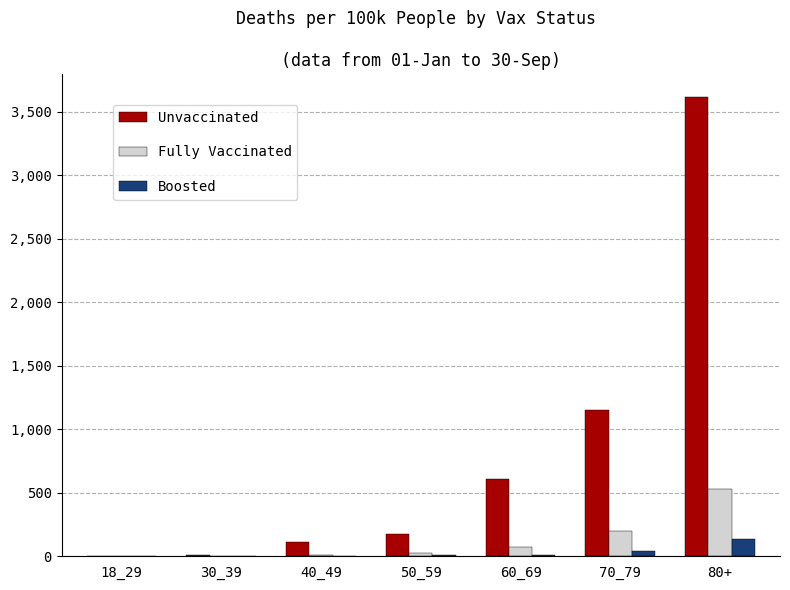

In [8]:
# Chart

def commaSep(x, pos): return ('{:,}'.format(x)).replace('.0', '')

plt.rcParams.update({'font.size': 10,
                     'font.family':'Monospace',
                     'grid.linestyle':'dashed'})
plt.rcParams["figure.figsize"] = [8,6]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()

df.plot(x='age', y=['Unvaccinated','Fully Vaccinated','Boosted'], kind='bar', 
        color=['#a70000','lightgray','#183f78'],
        align='center',
        width=0.7,linewidth=0.3,
        edgecolor='black',ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.grid(True)
ax.set_axisbelow(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.2, 0.95), ncol=1, labelspacing = 1.5, frameon=True, fancybox=True)
plt.xticks(rotation=0)
ax.yaxis.set_major_formatter(tkr.FuncFormatter(commaSep))
plt.tick_params(bottom=False)

plt.title('Deaths per 100k People by Vax Status \n\n' + 
          '(data from ' + date_min.strftime('%d-%b') + ' to ' + date_max.strftime('%d-%b') + ')')
plt.xlabel('')
plt.ylabel('')
plt.show()